In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import numpy as np
from PIL import Image

### Indice
1. Obtención del dataset
2. Analisis del dataset
3. Preprocesamiento del dataset
4. Creacion del modelo
5. Entrenamiento del modelo
6. Prediccion del modelo
7. Evaluacion del modelo
8. Conclusiones

#### 1. Obtención del dataset

Para la realizacion del Caso Kaggle, he decidido buscar un dataset similar al del https://www.kaggle.com/kvpratama/pokemon-images-dataset, ya que para lo que tenia en mente necesitaba la variante shiny de cada pokemon.
Para ello he utilizado la siguiente pagina https://pokemondb.net/pokedex/shiny y he extraido las imagenes de todos los pokemons.  
Para ello he preparado un script en javascript que busca las imagenes de todos los pokemons y coge la url de la imagen de shiny y el normal:

    function getUrls(class_name) {
        imgs_normal = document.getElementsByClassName(class_name);
        str = "";
        for (let i = 0; i < imgs_normal.length; i++) {
            if (imgs_normal[i].src != undefined) {
                str += imgs_normal[i].src + '\n';
            }
        }
        return str;
    }

    normal = getUrls('shinydex-sprite-normal');
    shini = getUrls('shinydex-sprite-shiny');

Con este obtenemos lo siguiente:    

![img](imgs/web1.png)

Como se puede apreciar en la imagen podemos ver todas las url de las imagenes de los pokemons.  
A continuacion utilizando la libreria `requests` he descargado las imagenes de los pokemons en formato png, el codigo es el siguiente:

    import requests

    FILE_NORMAL = 'links_normal.txt'
    FILE_SHINY = 'links_shiny.txt'

    DOWNLOADED_FOLDER = '../dataset/'

    def downloader(file_name):
        lines = open(file_name, 'r').read().split('\n')
        for line in lines:
            if line == '': continue
            url = line.split('/')
            name_img = DOWNLOADED_FOLDER + url[-2] + "/" + url[-1]
            print(f'Downloading {name_img}...')
            r = requests.get(line)
            open(f'{name_img}', 'wb').write(r.content)
            
    if __name__ == '__main__':
        downloader(FILE_NORMAL)
        downloader(FILE_SHINY)

De esta manera conseguimos descargar las imagenes de los pokemons y separarlas en dos carpetas, una para las imagenes normales y otra para las imagenes shiny.

#### 2. Analisis del dataset

En este apartado vamos a analizar el dataset y ver las imagenes descargadas y su resolucion. Y asegurarnos de que todos los poquemosn tiene una imagen de shiny y una imagen normal.

In [2]:
DATASET_URL_NORMAL = 'dataset/normal/'
DATASET_URL_SHINY = 'dataset/shiny/'

def compare_datasets(normal_images, shiny_images):
    a = os.listdir(normal_images)
    b = os.listdir(shiny_images)
    return [x for x in a if x not in b]

def read_dataset_images(path):
    """
    Reads images from a directory and returns a list of images.
    """
    images = []
    for filename in os.listdir(path):
        png = Image.open(path + filename)
        png.load()
        # Cambiamos el formato de la imagen a RGB con el fondo a blanco
        background = Image.new("RGB", png.size, (255, 255, 255))
        background.paste(png, mask=png.split()[3])
        images.append(np.asarray(background))
    return images

print('Incosistencias: ', len(compare_datasets(DATASET_URL_NORMAL, DATASET_URL_SHINY)))

shiny = read_dataset_images(DATASET_URL_SHINY)
normal = read_dataset_images(DATASET_URL_NORMAL)

Incosistencias:  0


Podemos ver que no tenemos incosistencias en el dataset, por lo que podemos proceder a seguir analizando el dataset.

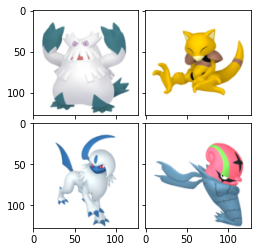

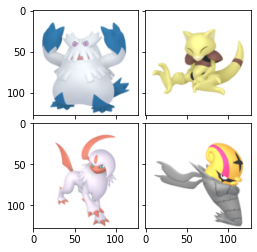

Dimension de la imagen:  (128, 128, 3)
Numero de imagenes:  895


In [3]:
def show_images(images, n_rows_cols=1):
    fig = plt.figure(figsize=(4, 4))
    grid = ImageGrid(   fig, 111,
                        nrows_ncols=(n_rows_cols, n_rows_cols),
                        axes_pad=0.1,
                    )
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()

show_images(normal, 2)
show_images(shiny, 2)

print('Dimension de la imagen: ', shiny[0].shape)
print('Numero de imagenes: ', len(shiny))

Podemos observar que el dataset tiene la cantidad de 895 * 2 imagenes, las cuales estan en formato .png, pero que se han leido como jpeg y se han pasado el canal alpha a blanco. Cada imagen tiene un tamaño de 128x128x3. En la parte superior de las imagenes tenemos los pokemons normales y en la parte inferior de las imagenes tenemos los pokemons shiny.

#### 3. Preprocesamiento del dataset

En este apartado vamos a tratar diferentes preprocesamientos tipicos que se realizan en imagenes. Pero antes de hacerlo vamos a separar el dataset datos de entrenamiento y datos de test. Las imagenes de los pokemons normales sera el input del pix2pix y las imagenes de los pokemons shiny sera el target.

In [4]:
TRAIN_SIZE = round(len(normal) * 0.8)

np.random.seed(42)

np.random.shuffle(normal)
np.random.shuffle(shiny)

X_train = normal[:TRAIN_SIZE]
X_test  = normal[TRAIN_SIZE:]
Y_train = shiny[:TRAIN_SIZE]
Y_test  = shiny[TRAIN_SIZE:]

print('Numero de imagenes de entrenamiento: ', len(X_train))
print('Numero de imagenes de prueba: ', len(X_test))

Numero de imagenes de entrenamiento:  716
Numero de imagenes de prueba:  179


Una vez separados los datos de entrenamiento y test, vamos a aumentar el dataset.

In [5]:
def normalize(inimg, tgimg):
    '''
        Normalizamos el rango de la imagen para que quede entre -1 y 1
    '''
    inimg = (inimg / 127.5) - 1
    tgimg = (tgimg / 127.5) - 1
    return inimg.astype(float), tgimg.astype(float)

def flip_image_vertical(inimg, tgimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 1)
    tgimg = np.flip(tgimg, 1)
    return inimg, tgimg

def flip_image_horizontal(inimg, tgimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 0)
    tgimg = np.flip(tgimg, 0)
    return inimg, tgimg

def data_augmentation(X, y):
    new_X = []
    new_y = []
    
    for i in range(len(X)-2):
        x_t, y_t = flip_image_vertical(X[i], y[i])
        new_X.append(x_t)
        new_y.append(y_t)
        
        x_t, y_t = flip_image_horizontal(X[i+1], y[i+1])
        new_X.append(x_t)
        new_y.append(y_t)
        
        x_t, y_t = flip_image_vertical(X[i+2], y[i+2])
        x_t, y_t = flip_image_horizontal(x_t, y_t)
        new_X.append(x_t)
        new_y.append(y_t)
        
    return new_X, new_y

for i in range(len(X_train)):
    X_train[i], Y_train[i] = normalize(X_train[i], Y_train[i])

X_train, Y_train = data_augmentation(X_train, Y_train)
X_train = torch.from_numpy(np.stack(X_train))
Y_train = torch.from_numpy(np.stack(Y_train))

In [6]:
X_train.shape

torch.Size([2142, 128, 128, 3])